In [2]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [3]:
# Set up paths

path_to_data = '/expanse/nfs/cw3e/cwp140/'     # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
fname = os.path.join(path_to_data, 'preprocessed/SEAK-WRF-PCPT/PCPT_quantiles.nc')
ds = xr.open_dataset(fname)
ds = ds.sel(quantile=0.95)
ds

<xarray.Dataset>
Dimensions:   (y: 250, x: 320)
Coordinates:
    lat       (y, x) float32 ...
    lon       (y, x) float32 ...
    quantile  float64 0.95
Dimensions without coordinates: y, x
Data variables:
    PCPT      (y, x) float64 ...

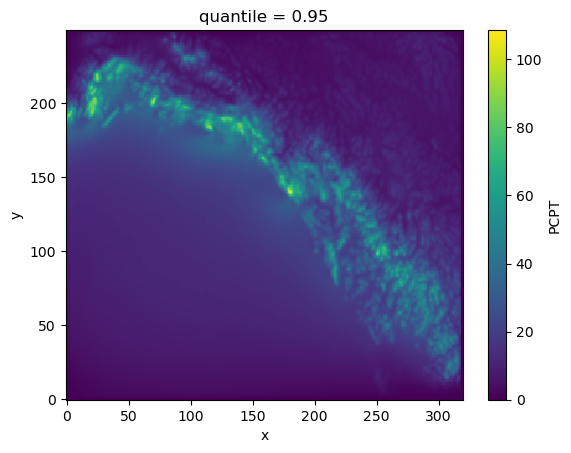

In [5]:
ds.PCPT.plot()

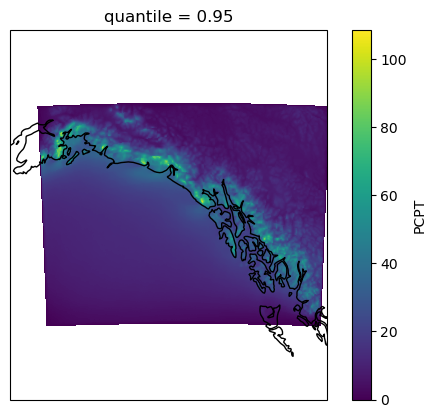

In [6]:
mapcrs = ccrs.LambertConformal(central_longitude=-138.5, central_latitude=58.0)
datacrs = ccrs.PlateCarree()

p = ds.PCPT.plot(x='lon', y='lat',
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},
)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-150, -129, 50, 65])

In [22]:
## bounding boxes for composite analysis
bboxes = [[-140.5, -137., 58.25, 60.75], # Yakutat (Northern Coastal)
          [-136.5, -134.75, 56.0, 58.25], # Sitka / Hoonah (Central Coastal)
          [-137.0, -134.75, 58.25, 60.5], # Skagway/Klukwan/Haines (Northern Inner Channel)
          [-134.75, -132.5, 56.75, 58.5], # Juneau/Hoonah/Gustavas (Central Inner Channel)
          [-134.25, -132.5, 54.25, 56.75], # Craig (Southern Coastal)
          [-132.5, -131.25, 54.5, 56.75]] # Kasaan (Southern Inner Channel)

zone_lst = ['northern_inner_coastal', 'central_coastal', 'northern_inner_channel', 'central_inner_channel', 'southern_coastal', 'southern_inner_channel']

In [8]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
varname = 'PCPT' # 'PCPT' or 'UV'

fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format(varname)
wrf = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')
if temporal_res == 'hourly':
    wrf = wrf
elif (temporal_res == 'daily') & (varname == 'PCPT'):
    wrf = wrf.resample(time="1D").sum('time') # resample WRF data to be mm per day
    
elif (temporal_res == 'daily') & (varname == 'UV'):
    wrf = wrf.sel(lev='1000')
    wrf = wrf.resample(time="1D").mean('time') # resample WRF data to be m s-1

wrf

<xarray.Dataset>
Dimensions:  (time: 14610, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    PCPT     (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Sat Dec  8 15:40:16 AKST 2018

In [11]:
%%time
total_grid_ct = []
for i, ext in enumerate(bboxes):
    idx = (wrf.lat >= ext[2]) & (wrf.lat <= ext[3]) & (wrf.lon >= ext[0]) & (wrf.lon <= ext[1])
    mask = wrf.where(idx)
    tmp = mask.isel(time=0)
    grid_ct = tmp.PCPT.count(['y', 'x']).compute()
    total_grid_ct.append(grid_ct.values)

CPU times: user 25.5 s, sys: 127 ms, total: 25.6 s
Wall time: 25.7 s


In [12]:
total_grid_ct

[array(3444), array(1649), array(1992), array(1629), array(1916), array(1230)]

In [14]:
%%time
## use where statement to get dates where precip > 95th percentile
wrf = wrf.where(wrf.PCPT >= ds.PCPT)
wrf = wrf.compute()

CPU times: user 1min 43s, sys: 1min 37s, total: 3min 21s
Wall time: 5min 41s


In [15]:
%%time
## temporarily subset to the region
ext = bboxes[0]
idx = (wrf.lat >= ext[2]) & (wrf.lat <= ext[3]) & (wrf.lon >= ext[0]) & (wrf.lon <= ext[1])
mask = wrf.where(idx)

## use where statement to get dates where precip > 95th percentile
grid_ct = mask.PCPT.count(['y', 'x'])
grid_ct

CPU times: user 1.77 s, sys: 494 ms, total: 2.26 s
Wall time: 2.26 s


<xarray.DataArray 'PCPT' (time: 14610)>
array([  0,   4,   0, ..., 224, 766, 329])
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    quantile  float64 0.95

In [19]:
test = (grid_ct/total_grid_ct[0])*100

test.where(test >= 50., drop=True)

<xarray.DataArray 'PCPT' (time: 467)>
array([71.34146341, 50.98722416, 75.69686411, 96.8641115 , 65.6213705 ,
       57.34610918, 74.15795587, 81.06852497, 79.87804878, 54.44250871,
       67.07317073, 67.04413473, 76.39372822, 57.5203252 , 76.16144019,
       69.54123113, 78.1358885 , 73.17073171, 51.56794425, 72.99651568,
       61.38211382, 64.05342625, 67.16027875, 65.50522648, 74.44831591,
       63.7340302 , 50.        , 52.90360046, 53.51335656, 58.97212544,
       55.48780488, 75.029036  , 72.73519164, 54.79094077, 58.01393728,
       57.78164925, 71.48664344, 61.61440186, 78.01974448, 58.88501742,
       65.56329849, 66.28919861, 90.15679443, 64.02439024, 91.57955865,
       87.25319396, 77.87456446, 80.72009292, 78.1068525 , 59.43670151,
       79.47154472, 69.88966318, 51.56794425, 73.28687573, 87.92102207,
       82.54936121, 79.09407666, 68.87340302, 61.06271777, 51.82926829,
       57.20092915, 51.07433217, 66.43437863, 57.57839721, 53.25203252,
       72.61904762, 70.58652729, 63.61788618, 68.20557491, 92.42160279,
       81.41695703, 61.55632985, 70.93495935, 51.97444832, 66.84088269,
       99.94192799, 65.09872242, 52.75842044, 80.83623693, 68.40882695,
       95.06387921, 93.757259  , 93.03135889, 95.73170732, 83.91405343,
       68.00232288, 68.49593496, 77.84552846, 84.03019744, 53.22299652,
       90.56329849, 86.12078978, 52.17770035, 55.6039489 , 58.33333333,
       62.31126597, 98.83855981, 55.54587689, 76.04529617, 62.485482  ,
...
       66.08594657, 57.92682927, 61.8466899 , 75.75493612, 82.02671312,
       60.36585366, 95.41231127, 57.81068525, 65.36004646, 98.54819977,
       73.05458769, 79.23925668, 95.32520325, 82.86875726, 99.88385598,
       52.70034843, 57.89779326, 68.96051103, 99.59349593, 50.69686411,
       65.24390244, 84.69802555, 53.97793264, 57.69454123, 79.41347271,
       65.06968641, 79.3554007 , 57.95586527, 75.37746806, 81.93960511,
       81.271777  , 70.12195122, 50.87108014, 58.94308943, 60.19163763,
       65.50522648, 58.97212544, 76.45180023, 77.87456446, 54.41347271,
       87.485482  , 55.92334495, 61.70150987, 71.95121951, 66.28919861,
       86.58536585, 58.24622532, 80.80720093, 71.16724739, 66.08594657,
       79.73286876, 91.92799071, 52.84552846, 56.62020906, 74.04181185,
       86.70150987, 81.82346109, 63.1242741 , 99.12891986, 90.38908246,
       67.21835075, 71.48664344, 97.67711963, 84.49477352, 61.09175377,
       86.38211382, 93.90243902, 99.33217189, 64.16957027, 96.37049942,
       99.3902439 , 87.54355401, 57.57839721, 74.73867596, 86.64343786,
       72.18350755, 80.57491289, 79.12311266, 50.20325203, 63.0952381 ,
       83.21718931, 51.74216028, 65.38908246, 88.0952381 , 72.24157956,
       67.88617886, 70.67363531, 62.10801394, 79.3554007 , 71.37049942,
       94.88966318, 89.75029036, 89.83739837, 93.26364692, 70.6155633 ,
       98.1126597 , 85.6562137 ])
Coordinates:
  * time      (time) datetime64[ns] 1980-10-07 1980-10-08 ... 2019-11-22
    quantile  float64 0.95

In [24]:
%%time
for i, ext in enumerate(bboxes):
    ## temporarily subset to the region
    idx = (wrf.lat >= ext[2]) & (wrf.lat <= ext[3]) & (wrf.lon >= ext[0]) & (wrf.lon <= ext[1])
    mask = wrf.where(idx)
    
    ## get number of grids where prec >=95th percentile
    grid_ct = mask.PCPT.count(['y', 'x'])
    grid_perc = (grid_ct/total_grid_ct[i])*100
    final_dates = grid_perc.where(grid_perc >= 50., drop=True).time.values

    d = {'date': final_dates}
    df = pd.DataFrame(data=d)
    df.to_csv('../out/{0}_95th_percentile_precip_dates.csv'.format(zone_lst[i]))

CPU times: user 11.2 s, sys: 3.06 s, total: 14.3 s
Wall time: 14.5 s


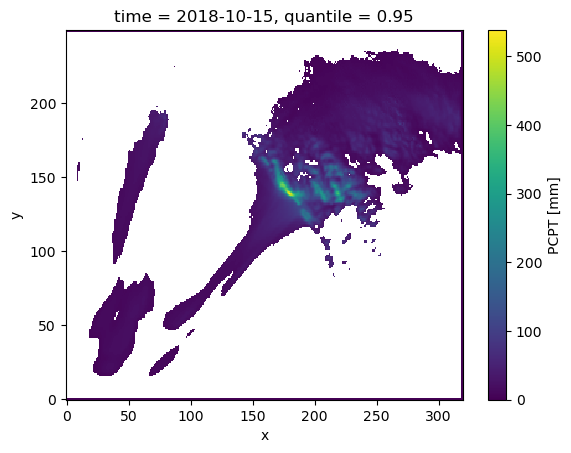

In [8]:
tmp.sel(time='2018-10-15').PCPT.plot()

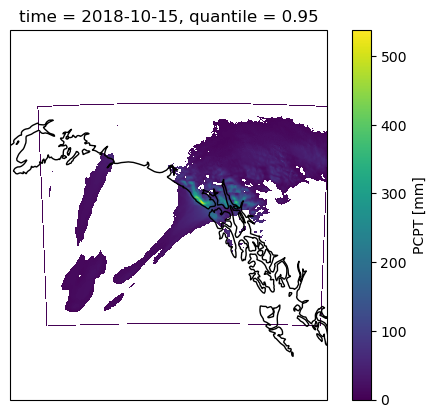

In [9]:
mapcrs = ccrs.LambertConformal(central_longitude=-138.5, central_latitude=58.0)
datacrs = ccrs.PlateCarree()

p = tmp.sel(time='2018-10-15').PCPT.plot(x='lon', y='lat',
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},
)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-150, -129, 50, 65])